<a href="https://colab.research.google.com/github/brdeleon/flagging_loans_shapley_values/blob/main/flagging_loans_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flagging Loans
## Imports

In [37]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import warnings
warnings.filterwarnings("ignore")

import joblib as jb
from joblib import dump, load

import os
import shap
import math
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


### Importing Data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
df = pd.read_csv('/content/drive/MyDrive/loan_data/df.csv')

In [44]:
# Previewing first 5 rows and last 5 rows of the dataset
df.head().append(df.tail())

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,...,age,gender,bad_flag,rep_loan_year,rep_loan_month,rep_loan_day,first_loan_year,first_loan_month,first_loan_day,days_between_rep_and_first_loan
0,708382,0.0,0.0,0.0,3.0,region_6,6,0,0,10,...,21.0,0,0,2016,10,6,2015,11,13,328
1,406305,1.0,0.0,0.0,0.0,region_6,6,0,0,6,...,20.0,0,0,2016,3,26,2015,9,28,180
2,779736,0.0,0.0,0.0,2.0,region_1,6,0,0,0,...,19.0,0,0,2016,10,30,2015,12,21,314
3,556376,0.0,0.0,0.0,1.0,region_6,14,0,0,4,...,21.0,0,0,2016,6,29,2015,6,30,365
4,266968,0.0,0.0,0.0,0.0,region_5,22,0,3,0,...,33.0,0,0,2015,12,1,2015,8,3,120
4126,533637,0.0,0.0,0.0,0.0,region_5,7,0,0,1,...,26.0,0,0,2016,6,11,2016,5,17,25
4127,596156,0.0,0.0,0.0,1.0,region_2,12,0,0,4,...,38.0,0,1,2016,8,6,2016,3,11,148
4128,645359,0.0,0.0,0.0,1.0,region_2,12,0,0,4,...,21.0,0,0,2016,9,5,2016,4,30,128
4129,730681,0.0,0.0,0.0,0.0,region_6,7,0,0,4,...,35.0,0,0,2016,10,14,2016,5,20,147
4130,521420,2.0,2.0,0.0,0.0,region_4,12,0,0,6,...,25.0,0,1,2016,6,2,2015,12,8,177


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4131 entries, 0 to 4130
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   loanKey                          4131 non-null   int64  
 1   dpd_5_cnt                        4131 non-null   float64
 2   dpd_15_cnt                       4131 non-null   float64
 3   dpd_30_cnt                       4131 non-null   float64
 4   close_loans_cnt                  4131 non-null   float64
 5   federal_district_nm              4131 non-null   object 
 6   TraderKey                        4131 non-null   int64  
 7   payment_type_0                   4131 non-null   int64  
 8   payment_type_1                   4131 non-null   int64  
 9   payment_type_2                   4131 non-null   int64  
 10  payment_type_3                   4131 non-null   int64  
 11  payment_type_4                   4131 non-null   int64  
 12  past_billings_cnt   

## Modeling

### Evaluation Function

In [46]:
# Defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_test, y_train, y_test, classes=None, 
                            normalize='true', cmap='Reds', label=''):
    
    """Input a model, training data and validation data to return sklearn metrics
        - Classification Report for training and validation 
        - PR AUC Score for training and validation 
        - Confusion Matrix for training and validation 
        - ROC Curve for training and validation
        - PR Curve for training and validation
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_test: train_test_split 
        y_train: train_test_split & preprocessed
        y_test: train_test_split 
        label: optional label for type of classifier 
    """
    # retrieve predictions for train and validation data 
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # retrieve probabilites for train and validation data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_test = model.predict_proba(X_test)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_test = y_hat_test[:, 1]
    
    # print training classification report 
    header = label + " Classification Report Training "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # Display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_train, y=y_train, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')    
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_train, y_train, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Training')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    fig.tight_layout()
    plt.show()

    # print validation classification report 
    header_ = label + "Classification Report Test"
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names=classes))
    
    # display validation figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_test, y=y_test, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Test')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Test')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Test')
    plt.legend()
    fig.tight_layout()
    plt.show()

### Data Split

Split data into training and test sets. Training set is used to train the machine learning model, training set is used to evaluate performance of models during training, and the test set is used to evaluate final performance. It is important that the class distribution is preserved across the sets. We specify for data to be split in a stratified fashion, using the class labels. Using stratification helps ensure that the proportion of the target class in each split is close to that of the original data for a fair comparison. (Data School)

In [47]:
# Defining x and y for data split
X = df.drop('bad_flag', axis=1)
y = df['bad_flag']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Object Type Data

In [48]:
# Use ColumnTransformer to apply preprocessing steps to the categorical features
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse=False), ['federal_district_nm']),
],
    remainder="passthrough" # remainder data will pass through without transformation, instead of being dropped
)

In [49]:
# Apply preprocessing steps to the training data
X_train = preprocessor.fit_transform(X_train)

# Apply preprocessing steps to the testing data
X_test = preprocessor.transform(X_test)

In [50]:
# One-hot encode the federal_district_nm column
encoder = preprocessor.named_transformers_['ohe']
column_names = encoder.get_feature_names_out(['federal_district_nm'])
new_columns = list(column_names) + [col for col in X.columns if col not in ['federal_district_nm']]

In [51]:
X_train = pd.DataFrame(X_train, columns= new_columns)
X_test = pd.DataFrame(X_test, columns= new_columns)

In [52]:
# Check the columns of the data
print(f"X_train columns: {X_train.columns}") 
print(f"X_test columns: {X_test.columns}")

X_train columns: Index(['federal_district_nm_region_0', 'federal_district_nm_region_1',
       'federal_district_nm_region_2', 'federal_district_nm_region_3',
       'federal_district_nm_region_4', 'federal_district_nm_region_5',
       'federal_district_nm_region_6', 'federal_district_nm_region_7',
       'loanKey', 'dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt',
       'TraderKey', 'payment_type_0', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'past_billings_cnt', 'score_1',
       'age', 'gender', 'rep_loan_year', 'rep_loan_month', 'rep_loan_day',
       'first_loan_year', 'first_loan_month', 'first_loan_day',
       'days_between_rep_and_first_loan'],
      dtype='object')
X_test columns: Index(['federal_district_nm_region_0', 'federal_district_nm_region_1',
       'federal_district_nm_region_2', 'federal_district_nm_region_3',
       'federal_district_nm_region_4', 'federal_district_nm_region_5',
       'federal_district_nm_region_6', 

### Pipeline Building

To avoid data leakage we will build a model using a pipeline. Using pipeline helps prevent data leakage by creating a clear separation between the preprocessing and modeling steps.


**Next:** We will add sampling techniques to help the model with the imbalanced data. The sampling techniques will require an imblearn pipeline

### Random Forest imblearn pipeline

In [53]:
# Define the under and over samplers
undersampler = RandomUnderSampler(sampling_strategy=0.5, 
                         random_state=42)
oversampler = RandomOverSampler(sampling_strategy='minority', 
                        random_state=42)

# Define the random forest classifier
classifier = RandomForestClassifier(max_depth=10, 
                            min_samples_split=10, 
                            n_estimators=300, 
                            max_features='sqrt', 
                            class_weight='balanced_subsample', 
                            random_state=42)

In [54]:
# Define the pipeline
final_pipeline = imbPipeline(steps=[
    ('undersampler', undersampler), 
    ('oversampler', oversampler), 
    ('classifier', classifier)])

In [55]:
# Fit the pipeline
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('oversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_split=10,
                                        n_estimators=300, random_state=42))])

------------------------------------------------------------
Under and Over Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2974
           1       0.38      0.94      0.54       330

    accuracy                           0.84      3304
   macro avg       0.69      0.89      0.72      3304
weighted avg       0.93      0.84      0.87      3304



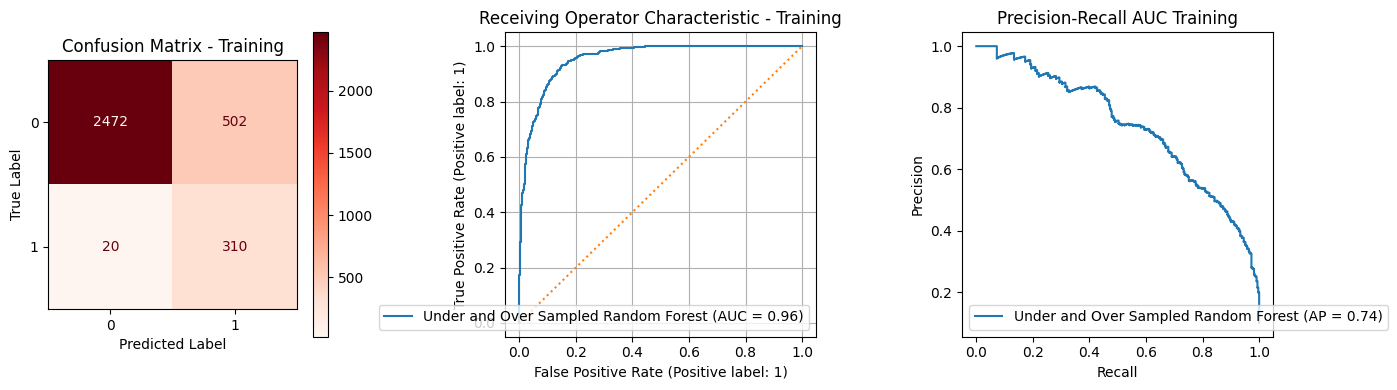

------------------------------------------------------------
Under and Over Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       745
           1       0.26      0.66      0.38        82

    accuracy                           0.78       827
   macro avg       0.61      0.73      0.62       827
weighted avg       0.89      0.78      0.82       827



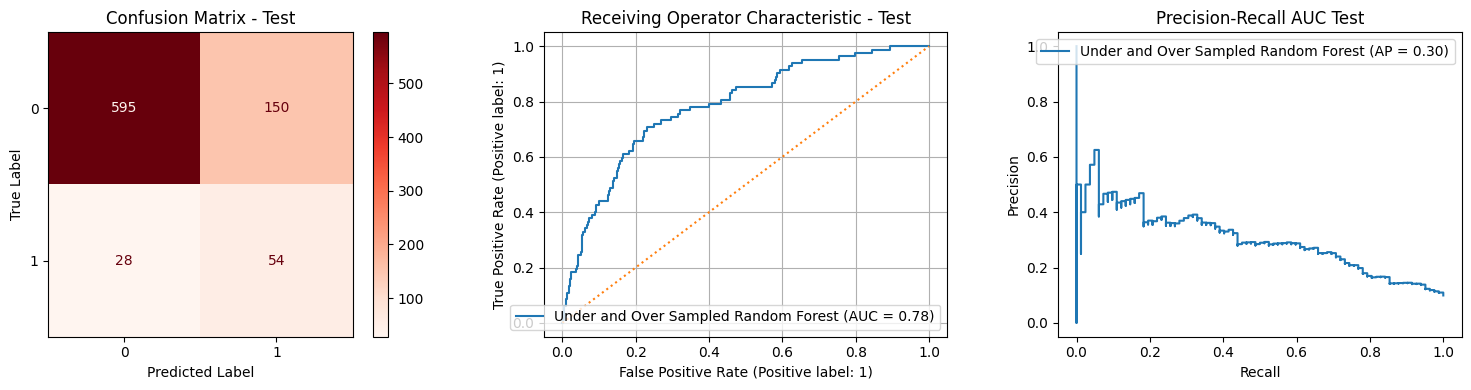

In [56]:
# Classification report using function 
evaluate_classification(final_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under and Over Sampled Random Forest')

### Final Test

In [57]:
# Use the final test set to evaluate the pipeline
y_pred = final_pipeline.predict(X_test)
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test macro recall: ", recall_test)

Test macro recall:  0.7285971517433295


## Permutation Importance

In [58]:
# from sklearn documentation
# number of times a feature is randomly shuffled specified to: 30
features = permutation_importance(final_pipeline, 
                                 X_test, 
                                 y_test, 
                                 n_repeats=30, 
                                 scoring='recall_macro', 
                                 random_state=42)

In [59]:
# from sklearn documentation
# probing which features are most predictive
for i in features.importances_mean.argsort()[::-1]:
     if features.importances_mean[i] - 2 * features.importances_std[i] > 0:
         print(f"{X_test.columns[i]:<8}"
               f"{features.importances_mean[i]:.3f}"
               f" +/- {features.importances_std[i]:.3f}")

score_1 0.100 +/- 0.017
dpd_5_cnt0.038 +/- 0.010
close_loans_cnt0.023 +/- 0.007
loanKey 0.016 +/- 0.008
federal_district_nm_region_40.005 +/- 0.002


In [61]:
# Calculate the SHAP values for the test set
explainer = shap.TreeExplainer(final_pipeline)
shap_values = explainer(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test)
plt.show()

InvalidModelError: ignored

In [62]:
rf = final_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)


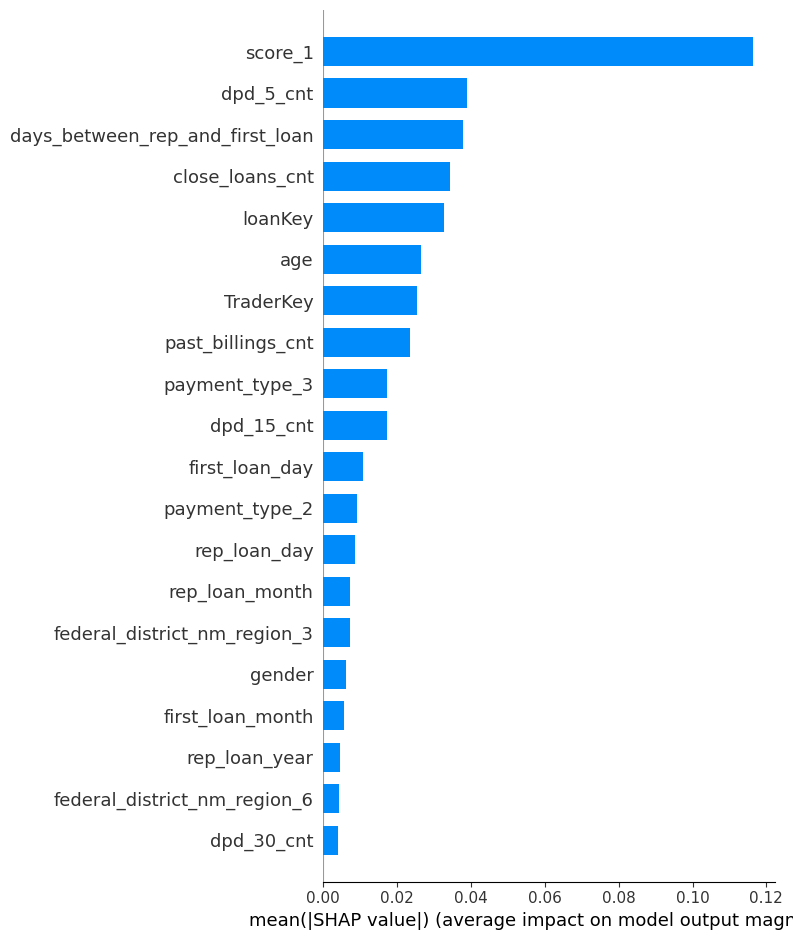

In [63]:
shap.summary_plot(shap_values[1], X_train, plot_type='bar', show=False)
plt.show()


In [64]:
shap_values_test = explainer.shap_values(X_test)

In [65]:
shap.force_plot(explainer.expected_value[1], shap_values_test[1][0,:], X_test.iloc[0,:])

In [67]:
initjs()

NameError: ignored